In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam # - Works
# from keras.optimizers import Adam


In [7]:
data = pd.read_csv("/content/A_Z Handwritten Data.csv").astype('float32')
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
width, height, channel = 28, 28, 1


In [11]:
X = data.iloc[:,1:].values
# X = X.reshape((372450, width, height))
np.random.shuffle(X)
X.shape


(13942, 784)

In [12]:
X = (X - 127.5) / 127.5


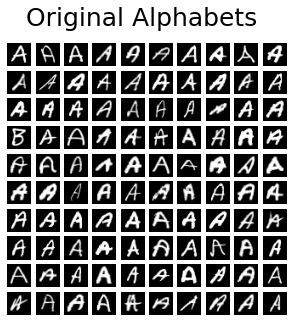

In [16]:
def show_data(X, title=""):
    plt.figure(figsize=(5,5))
    
    i = 1
    for img in X:
        plt.subplot(10,10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [17]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100


In [18]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [19]:
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_1 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 6272)              0

In [20]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [21]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)              

In [22]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [23]:
gan.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         6595073   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


In [24]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))


In [25]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()


In [26]:
epochs = 10
batch_size = 128
steps_per_epoch = len(X)//batch_size


epoch:  0
discriminator loss:  0.42880985140800476
generator loss:  1.0466935634613037
--------------------------------------------------------------------------------


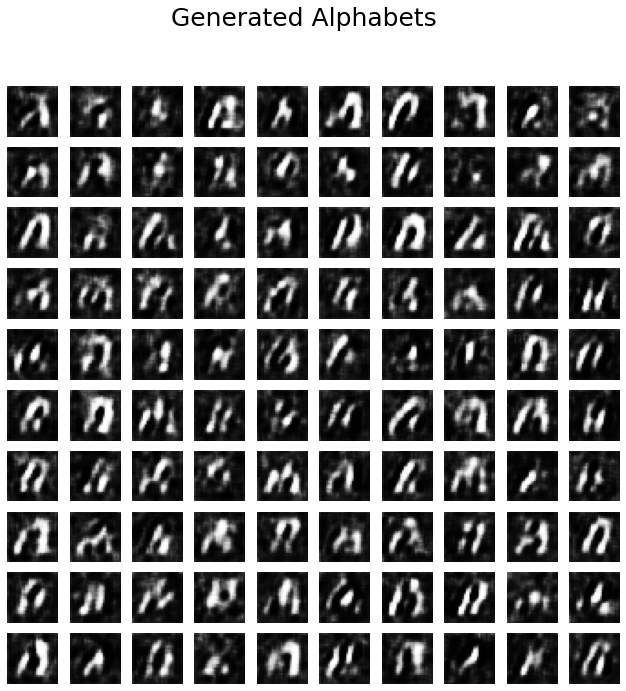

epoch:  1
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  2
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  3
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  4
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  5
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


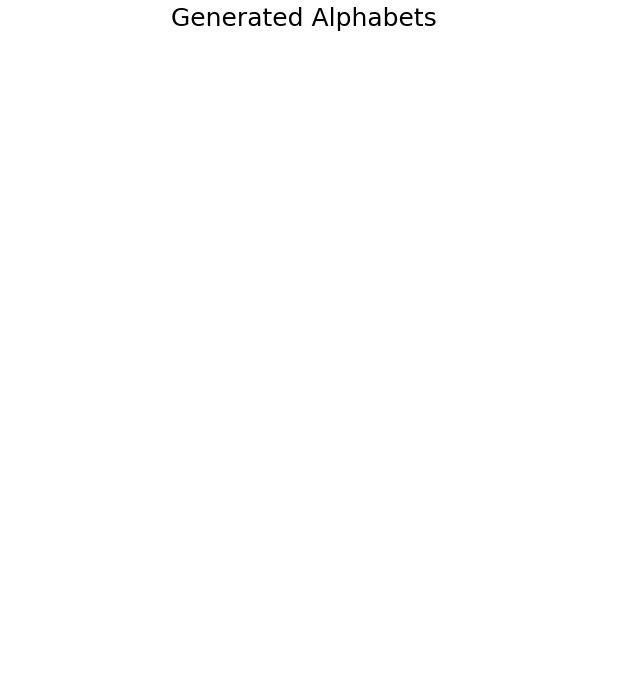

epoch:  6
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  7
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  8
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------
epoch:  9
discriminator loss:  nan
generator loss:  nan
--------------------------------------------------------------------------------


In [27]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)